# XGBoost (Extreme Gradient Boosting)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm

## Data

In [2]:
breast_cancer = pd.read_csv('../Data/breast_cancer.csv')
breast_cancer.drop(['id'], axis=1, inplace=True)
breast_cancer_dummies = pd.get_dummies(breast_cancer, columns=['diagnosis'], drop_first=True)
breast_cancer_dummies.rename(columns={'diagnosis_M': 'Malignant'}, inplace=True)
breast_cancer_dummies.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Malignant
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,1
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,1
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,1
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,1
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,1


In [14]:
inputs = breast_cancer_dummies.iloc[:, :-1]
target = breast_cancer_dummies.Malignant
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(inputs, target, test_size=0.2, random_state=0)

## AdaBoost Model

In [15]:
import xgboost as xgb

In [16]:
# Convert the dataset into an optimized data structure called Dmatrix that XGBoost supports and gives it acclaimed performance and efficiency gains
d_matrix = xgb.DMatrix(data=X_train, label=y_train)

## XGBoosts Hyperparameters
* <b>learning_rate</b: step size shrinkage used to prevent overfitting. Range is [0,1]
* <b>max_depth</b>: determines how deeply each tree is allowed to grow during any boosting round.
* <b>subsample</b>: percentage of samples used per tree. Low value can lead to underfitting.
* <b>colsample_bytree</b>: percentage of features used per tree. High value can lead to overfitting.
* <b>n_estimators</b>: number of trees you want to build.
* <b>objective</b>: determines the loss function to be used like reg:linear for regression problems, reg:logistic for classification problems with only decision, binary:logistic for classification problems with probability.

XGBoost also supports regularization parameters to penalize models as they become more complex and reduce them to simple (parsimonious) models.

* <b>gamma</b>: controls whether a given node will split based on the expected reduction in loss after the split. A higher value leads to fewer splits. Supported only for tree-based learners.
* <b>alpha</b>: L1 regularization on leaf weights. A large value leads to more regularization.
* <b>lambda</b>: L2 regularization on leaf weights and is smoother than L1 regularization.

In [17]:
xg_reg = xgb.XGBClassifier(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                           max_depth = 5, alpha = 10, n_estimators = 10)
xg_reg.fit(X_train, y_train)

[07:48:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.3,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=10, n_jobs=0,
              num_parallel_tree=1, objective='reg:linear', predictor='auto',
              random_state=0, ...)

In [11]:
from sklearn.metrics import mean_squared_error
y_pred = xg_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("R Mean Squared Error: ", rmse)

R Mean Squared Error:  0.22941573387056177


## k-fold Cross Validation using XGBoost

In order to build more robust models, it is common to do a k-fold cross validation where all the entries in the original training dataset are used for both training as well as validation

Also, each entry is used for validation just once. XGBoost supports k-fold cross validation via the cv() method. All you have to do is specify the nfolds parameter, which is the number of cross validation sets you want to build. It also supports other parameters:

* num_boost_round: denotes the number of trees you build (analogous to n_estimators)
* metrics: tells the evaluation metrics to be watched during CV
* as_pandas: to return the results in a pandas DataFrame.
* early_stopping_rounds: finishes training of the model early if the hold-out metric ("rmse" in our case) does not improve for a given number of rounds.
* seed: for reproducibility of results.

In [22]:
params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.1, 'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=d_matrix, params=params, nfold=3, num_boost_round=50, early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=0)


In [23]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,0.464400,0.000128,0.467612,0.000784
1,0.433558,0.001379,0.440060,0.002308
2,0.405461,0.001053,0.414142,0.003022
3,0.380336,0.000987,0.392044,0.003746
4,0.358289,0.000685,0.371753,0.004753


In [24]:
cv_results['test-rmse-mean'].tail(1)

49    0.225068
Name: test-rmse-mean, dtype: float64

## Plotting Important Features

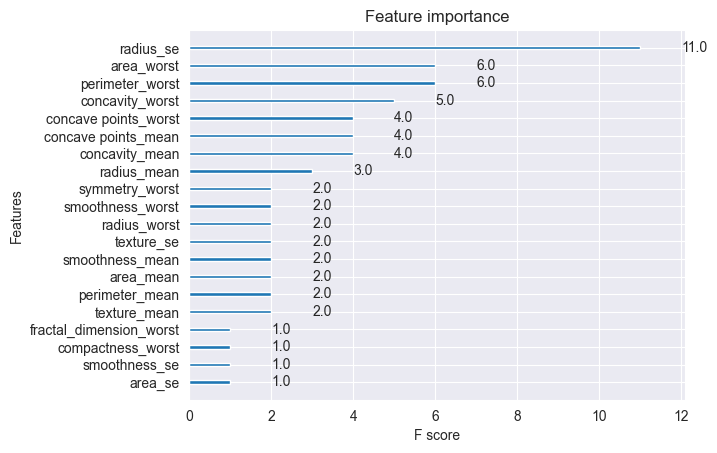

In [25]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

## Individual Tree Visualisation

ImportError: You must install graphviz to plot tree

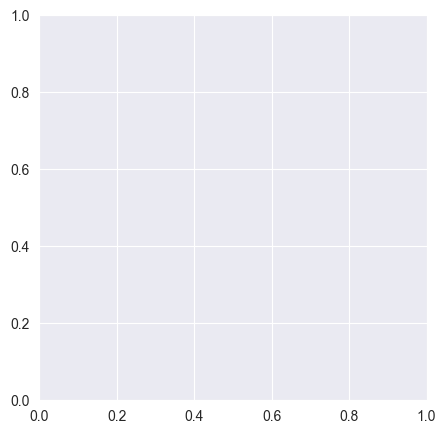

In [26]:
import matplotlib.pyplot as plt

xgb.plot_tree(xg_reg,num_trees=0)
plt.rcParams['figure.figsize'] = [50, 10]
plt.show()